# YOUR PROJECT TITLE

> **Note the following:** 
> 1. This is *not* meant to be an example of an actual **model analysis project**, just an example of how to structure such a project.
> 1. Remember the general advice on structuring and commenting your code from [lecture 5](https://numeconcopenhagen.netlify.com/lectures/Workflow_and_debugging).
> 1. Remember this [guide](https://www.markdownguide.org/basic-syntax/) on markdown and (a bit of) latex.
> 1. Turn on automatic numbering by clicking on the small icon on top of the table of contents in the left sidebar.
> 1. The `modelproject.py` file includes a function which could be used multiple times in this notebook.

Imports and set magics:

In [2]:
import numpy as np
from scipy import optimize
from scipy.optimize import fsolve
import sympy as sm
import matplotlib.pyplot as plt

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# local modules
import modelproject

# Model description

We consider the **standard OLG-model** where:

We assume that utility is given by $u(c)$ with constant relative risk aversion (CRRA utility function): 

\begin{equation}
  u(c)=\begin{cases}
    \frac{c^{1-\sigma}-1}{1-\sigma} , & \sigma ≠ 1 \\
    log c, & \sigma = 1
  \end{cases}
\end{equation}

Individuals live for two periods, t = 1,2. $L_t$ individuals are born in period t and we assume that the population grows with a constant rate, n: 

$$ L_t = L_{t-1}(1+n) $$

agents derive utility while alive: 

$$ U_t = u(c_{1t})+\frac{1}{1+\rho} u(c_{2t}) $$

Agtens' budget constraint in each period is given by: 

$$ c_{1t} + s_t = w_t $$

$$ c_{2t+1} = (1+r_{t+1}) s_t $$

This implies that agents' lifetime budget constraint is given by: 

$$ c_{1t} + \frac{c_{2t+1}}{1+r_{t+1}} = w_t $$



# Analytical solution

## Household problem

Every agtens born at time t maximize utility subject to their lifetime budget constraint:

First we define all **symbols**:

In [9]:
c_1t = sm.symbols('c_1t')
c_2t = sm.symbols('c_2t+1')
rho = sm.symbols('rho')
u_1 = sm.symbols('u_1')
u_2 = sm.symbols('u_2')
sigma = sm.symbols('sigma')
w = sm.symbols('w_t')
r_t1 = sm.symbols('r_t+1')
lamb = sm.symbols('lambda')
s = sm.symbols('s_t')
k_2t = sm.symbols('k_t+1')
k_1t = sm.symbols('k_t')
alpha = sm.symbols('alpha')
n = sm.symbols('n')
k_star = sm.symbols('k^*')

In [10]:
#Lifetime utility
u_c1 = sm.ln(c_1t)
u_c2 = sm.ln(c_2t)
U = u_c1 + u_c2/(1+rho)
U

log(c_1t) + log(c_2t+1)/(rho + 1)

In [11]:
# Lagrangian
budget_l = c_1t + c_2t/(1+r_t1) - w
L = U - lamb * budget_l
L



-lambda*(c_1t + c_2t+1/(r_t+1 + 1) - w_t) + log(c_1t) + log(c_2t+1)/(rho + 1)

In [12]:
def Lan(x):
    L_1 = sm.diff(L, x)
    L_2 = sm.Eq(L_1,0)
    L_3 = sm.solve(L_2, lamb) [0]
    return L_3

L_c1 = Lan(c_1t)
L_c2 = Lan(c_2t)

Eu = sm.Eq(L_c1, L_c2)
Eu_1 = sm.solve(Eu, c_2t) [0]
Euler = sm.Eq(c_2t, Eu_1)
Euler




Eq(c_2t+1, c_1t*(r_t+1 + 1)/(rho + 1))

In [13]:
budget_1 = w-s 
budget_2 = (1+r_t1)*s

savings_1 = Euler.subs(c_1t,budget_1)

savings_2 = savings_1.subs(c_2t, budget_2)

savings = sm.solve(savings_2,s)[0]

opt_savings = sm.Eq(s,savings)
opt_savings

Eq(s_t, w_t/(rho + 2))

In [14]:
# In equilibrium s = K*L = k
# We know that w is the marginal product of labor and given that the production function is a cobb-douglas we can insert w:

capital = sm.Eq(k_2t*(1+n), (((1-alpha)*k_1t**alpha)/(rho+2)))
capital

# In equilibrium k_t+1 = k_t = k^* so: 

capital_eq=sm.Eq(k_star*(1+n), (((1-alpha)*k_star**alpha)/(rho+2)))
Equilibrium = sm.solve(capital_eq,k_star)[0]
Equilibrium

((1 - alpha)/(n*rho + 2*n + rho + 2))**(-1/(alpha - 1))

## Numerical solution

We can re-write the equation for the steady state capital per capita as

\\[ 0 = \frac{1}{(1+n)(1+g)}[sf(\tilde{k}^{\ast})+(1-\delta)\tilde{k}^{\ast}] - \tilde{k}^{\ast} \\]

whereby it clearly becomes a **root-finding problem**. Such a problem can be solved by a **bisection method**.

Define the model **parameters**:

In [15]:
rho = 0.11
alpha = 0.3
n = 0.4
r = 0.2

**Solve numerically** for the steady state:

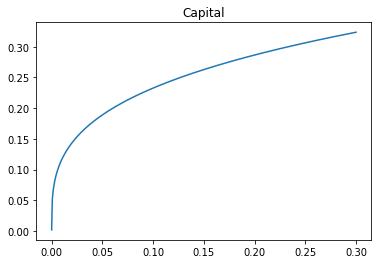

In [17]:
def func(k):
    s = 1/(2+rho)*(1-alpha)*k**alpha*(1+n)
    return s

ku = np.linspace(1e-8,0.3,500)
fku = np.zeros(len(ku),float)

for i,k in enumerate(ku):
    fku[i] = func(k)

fig, ax = plt.subplots()
ax.plot(ku,fku)
ax.set_title('Capital')
plt.show()

In [27]:
wstar = (1-alpha)*kstar**alpha
sstar = kstar/(1+n)
c1star = wstar-sstar
c2star = (1+r)*sstar

def u_func(c1star,c2star,rho):
    utility = c1star + (1/(1+rho))*c2star
    return utility

def objective(kstar,rho,alpha,n):
    kstar =  func(k)
    return -u_func(c1star,c2star,rho)

solutionk = optimize.minimize_scalar(
    objective,method='bounded',
    bounds=(0,1),args=(rho,alpha,n))

kstar = solutionk.x


print("k* = {:6.4}".format(kstar))

print("c1^* = {:6.4}".format(c1star))

print("c2^* = {:6.4}".format(c2star))


k* =    1.0
c1^* = -0.01428
c2^* = 0.8571


# Further analysis

ADD FURTHER ANALYSIS, VISUALIZATIONS AND EXTENSIONS.

# Conclusion

ADD CONCISE CONCLUSION.